# On the properties of variational approximations of Gibbs posteriors

##### Authors : Pierre Alquier, James Ridgway, Nicolas Chopin

##### Notebook created by Adrien Letellier \& Augustin Cablant 

[Article](https://arxiv.org/pdf/1506.04091)

### 1) **Introduction**
   - Overview of the context and objectives of the study.

### 2) **Framework**
   - Explanation of the theoretical framework and methods used in the paper.

### 3) **Assumptions**
   - Details of the underlying assumptions, including those of Bernstein and Hoeffding.

### 4) **Numerical approximations of the pseudo posterior**
   - Discussion on the numerical approximations of the pseudo-posterior, including:
     - Tempering SMC
     - Variational Bayes

### 5) **Applications**
   - a) Classification
   - b) [Other application to be detailed]

### 6) **Conclusion**
   - Summary of key conclusions and future directions.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
from numpy.linalg import eigvals
from scipy.optimize import minimize, bisect
from sklearn.datasets import fetch_openml
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from functools import partial
from SMC import Tempering_SMC
np.random.seed(2025)

# Introduction

 The Gibbs posterior (or pseudo-posterior $\hat{\rho _{\lambda}}$) is defined for all $\lambda > 0$ as : 
 
 $$\hat{\rho _{\lambda}} (\theta) \propto \exp\left(-\lambda r_n (\theta)\right) \pi(\theta), $$

where:

- $r_n( \theta )$ is an empirical measure of risk

- $\pi(\theta)$ is the prior.

> Estimators derived from Gibbs posteriors usually show excellent performance in diverse tasks, such as classification, regression, ranking. Usually, we sample from a Gibbs posterior using MCMC, but constructing an efficient MCMC sampler is often difficult. Instead we use VB (Variational Bayes) approximations.

# Framework

We observe a sample $(X_1, Y_1), \dots, (X_n, Y_n)$, taking values in $\mathcal{X} \times \mathcal{Y}$, where the pairs $(X_i, Y_i)$ have the same distribution $P$. We will assume explicitly that the $(X_i, Y_i)$’s are independent. 

A set of predictors is chosen by the statistician: 
$$
\{f_\theta : \mathcal{X} \to \mathbb{R}, \theta \in \Theta\}.
$$
For example, in linear regression, we may have: $f_\theta(x) = \langle \theta, x \rangle$, the inner product of $\mathcal{X} = \mathbb{R}^d$, while in classification, one may have $f_\theta(x) = \mathbb{I}_{\langle \theta, x \rangle > 0} \in \{0, 1\}$.

We assume we have at our disposal a risk function $R(\theta)$; typically $R(\theta)$ is a measure of the prevision error. We set $\bar{R} = R(\bar{\theta})$, where 
$$
\bar{\theta} \in \arg \min_\Theta R(\theta);
$$ 
i.e. $f_\bar{\theta}$ is an optimal predictor. We also assume that the risk function $R(\theta)$ has an empirical counterpart $r_n(\theta)$, and set $\bar{r}_n = r_n(\bar{\theta})$. 

Often, $R$ and $r_n$ are based on a loss function $l : \mathbb{R}^2 \to \mathbb{R}$; i.e. 
$$
R(\theta) = \mathbb{E}[l(Y, f_\theta(X))] \quad \text{and} \quad r_n(\theta) = \frac{1}{n} \sum_{i=1}^n l(Y_i, f_\theta(X_i)).
$$
(In this paper, the symbol $\mathbb{E}$ will always denote the expectation with respect to the (unknown) law $P$ of the $(X_i, Y_i)$’s.) There are situations however (e.g. ranking), where $R$ and $r_n$ have a different form.

We define a prior probability measure $\pi(\cdot)$ on the set $\Theta$ (equipped with the standard $\sigma$-algebra for the considered context), and we let $\mathcal{M}_1^+(\Theta)$ denote the set of all probability measures on $\Theta$.


# Assumptions 

## Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

$\quad $

## Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$

# Numerical approximations of the pseudo-posterior

The usual approach to approximate $\hat{\rho}_\lambda$ is MCMC (Markov chain Monte Carlo) sampling. Ridgway et al. [2014] proposed tempering SMC (Sequential Monte Carlo, e.g. Del Moral et al. [2006]) as an alternative to MCMC to sample from Gibbs posteriors: one samples sequentially from $\hat{\rho}_{\lambda_t}$, with $0 = \lambda_0 < \cdots < \lambda_T = \lambda$ where $\lambda$ is the desired temperature. One advantage of this approach is that it makes it possible to contemplate different values of $\lambda$, and choose one by, e.g., cross-validation. Another advantage is that such an algorithm requires little tuning; see Appendix B for more details on the implementation of tempering SMC. We will use tempering SMC as our gold standard in our numerical studies.

SMC and related Monte Carlo algorithms tend to be too slow for practical use in situations where the sample size is large, the dimension of $\Theta$ is large, or $f_\theta$ is expensive to compute. This motivates the use of fast, deterministic approximations, such as Variational Bayes, which we describe in the next section.

---

## Algorithm 1: Tempering SMC
1. **Input**: $N$ (number of particles), $\tau \in (0, 1)$ (ESS threshold), $\kappa > 0$ (random walk tuning parameter)
2. **Initialization**: Sample $\theta_0^i \sim \pi_\xi(\theta)$ for $i = 1$ to $N$, set $t \gets 1$, $\lambda_0 = 0$, $Z_0 = 1$.
3. **Loop**:
   a. Solve in $\lambda_t$ the equation:
   $$
   \frac{\left(\sum_{i=1}^N w_t(\theta_{t-1}^i)\right)^2}{\sum_{i=1}^N w_t(\theta_{t-1}^i)^2} = \tau N, \quad w_t(\theta) = \exp\left[-(\lambda_t - \lambda_{t-1}) r_n(\theta)\right]
   $$
   using bisection search.  
   If $\lambda_t \geq \lambda_T$:
   - Set $Z_T = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right)$, and stop.

   b. **Resample**: For $i = 1$ to $N$, draw $A_t^i$ in $\{1, \ldots, N\}$ so that:
   $$
   \Pr(A_t^i = j) = \frac{w_t(\theta_{t-1}^j)}{\sum_{k=1}^N w_t(\theta_{t-1}^k)}.
   $$

   c. **Propagate**: $\theta_t^i \gets \text{Perturb}(\theta_{t-1}^{A_t^i})$.

   d. Set:
   $$
   Z_t = Z_{t-1} \times \left(\frac{1}{N} \sum_{i=1}^N w_t(\theta_{t-1}^i)\right).
   $$

---

### Algorithm 2: Systematic Resampling
1. **Input**: Normalized weights $W_j := \frac{w_t(\theta_j)}{\sum_{i=1}^N w_t(\theta_i)}$.
2. **a.** Sample $U \sim \mathcal{U}([0, 1])$.
3. **b.** Compute cumulative weights as $C_n = \sum_{m=1}^n N W_m$.
4. **c.** Set $s \gets U$, $m \gets 1$.
5. **d.** For $n = 1$ to $N$:
   - While $C_m < s$:
     - $m \gets m + 1$.
   - Set $A_n \gets m$, $s \gets s + 1$.

In [2]:
### First we implement systematic resampling as defined in algorithm 2 of the paper. ###
def systematic_resampling(W):
    """
    Perform systematic resampling given a set of normalized weights.

    Args:
        W (numpy.ndarray): Array of normalized weights.
        W_t (float): Normalized weights of the current time step, size N.

    Returns:
       A (numpy.ndarray) : Indices of resampled particles.
    """
    N = len(W)
    U = np.random.uniform(0, 1)  # Step a: Sample U ~ U([0, 1])
    cumulative_weights = N * np.cumsum(W)  # Step b: Compute cumulative weights

    # Step c: Initialize variables
    s = U
    m = 1
    A = []
    # Step d: Resample
    for n in range(1, N + 1):
        while s > cumulative_weights[m]:
            m += 1
        A.append(m)
        s += 1 
    return np.array(A)


### Next we implement the SMC algorithm as defined in algorithm 1 of the paper. ###
def Tempering_SMC(N, tau, kappa, target_distribution, initial_distribution, likelihood_ratio):
    """ Perform the Tempering Sequential Monte Carlo (SMC) algorithm for Bayesian inference.

    Parameters
    ----------
    N : int
    Number of particles to use in the SMC algorithm.

    tau : float
        ESS threshold for resampling.

    rw : positive
        random walk tuning parameter.

    kappa : float
        Random walk tuning parameter.

    target_distribution : callable
        Target distribution function  pi

    initial_distribution : callable
        Initial distribution function pi_xi

    likelihood_ratio : callable
        Function computing r_n(theta)

    Returns:
    ----------
    list: List of particle states at each iteration. 
    """ 
    
    theta = [initial_distribution() for _ in range(N)]
    t = 1
    lambda_t = 0
    Z = 1
    results = []

    def program_bisec(lambd):
        w = np.exp(- (lambd - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        ratio = (np.sum(w) ** 2) / np.sum(w ** 2)
        return ratio - N * tau
    
    while True:
        # Step a: Solve for new lambda_t using bisection 
        lambda_new = bisect(program_bisec, lambda_t, 1)
        w = np.exp(- (lambda_new - lambda_t) * np.array([likelihood_ratio(p) for p in theta]))
        if lambda_new <= lambda_t:
            break 

        # Step b: Resample
        normalized_weights = w / np.sum(w)  
        A = systematic_resampling(normalized_weights)
        theta = [theta[a] for a in A]

        # Step c: MCMC step (Gaussian random-walk Metropolis kernel)
        cov = kappa * np.cov(np.array(theta).T)
        for i in range(N):
            proposal = theta[i] + np.random.multivariate_normal(np.zeros(len(theta[0])), cov)
            accept_ratio = min(1, target_distribution(proposal) / target_distribution(theta[i]))
            if np.random.uniform() < accept_ratio:
                theta[i] = proposal

    
        # Step d: Update normalizing constant Z
        Z *= np.mean(w)
        results.append((theta.copy(), Z))
 
    return results

## Variational Bayes

Variational Bayes (VB) is an approach to approximate $\hat{\rho}_\lambda$ by defining a family $\mathcal{F} \subset \mathcal{M}_1^+(\Theta)$ of tractable probability distributions. The VB approximation $\tilde{\rho}_\lambda$ is defined as:  
$$
\tilde{\rho}_\lambda = \arg\min_{\rho \in \mathcal{F}} K(\rho, \hat{\rho}_\lambda),
$$  
where $K(\rho, \hat{\rho}_\lambda)$ is the Kullback-Leibler (KL) divergence, defined as:  
$$
K(m, \mu) = 
\begin{cases} 
\int \log\left(\frac{dm}{d\mu}\right) dm & \text{if } m \ll \mu, \\
+\infty & \text{otherwise}.
\end{cases}
$$

The choice of $\mathcal{F}$ must balance two criteria:  
(a) $\mathcal{F}$ should be large enough for $\tilde{\rho}_\lambda$ to closely approximate $\hat{\rho}_\lambda$,  
(b) $\mathcal{F}$ should allow efficient computation of $\tilde{\rho}_\lambda$.  


$ \quad $

# Applications 

## Classification

In all this section, we assume that $ Y = \{0, 1\} $ and we consider linear classification: $ \Theta = X = \mathbb{R}^d $, $ f_\theta(x) = \mathbf{1}_{\langle \theta, x \rangle \geq 0} $. We put 

$$r_n(\theta) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}\{f_\theta(X_i) \neq Y_i\}, \quad R(\theta) = \mathbb{P}(Y \neq f_\theta(X)), $$

and assume that the $(X_i, Y_i)_{i=1}^n $ are i.i.d.
In this setting, it is well-known that the Hoeffding assumption always holds. That's to say:


### Hoeffding assumption

We say that a **Hoeffding assumption** is satisfied for prior $ \pi $ when there is a function $ f $ and an interval $ I \subset \mathbb{R}_+^* $ such that, for any $ \lambda \in I $, for any $ \theta \in \Theta $,

$$ \frac{\pi \left( \mathbb{E} \exp \{ \lambda [R(\theta) - r_n(\theta)] \} \right)}{\pi \left( \mathbb{E} \exp \{ \lambda [r_n(\theta) - R(\theta)] \} \right)} 
\leq \exp \big[ f(\lambda, n) \big]. \tag{1} $$

Here, Hoeffding assumption is satisfied with $f(\lambda, n) = \frac{\lambda^2}{2n}$.

### Bernstein assumption

We say that a Bernstein assumption is satisfied for prior $\pi$ when there is a function $g$ and an interval $I \subset \mathbb{R}_+^*$ such that, for any $\lambda \in I$, for any $\theta \in \Theta$,
$$
\frac{\pi \left( \mathbb{E} \exp \left\{ \lambda [R(\theta) - R^*] - \lambda [r_n(\theta) - r_n^*] \right\} \right)}
{\pi \left( \mathbb{E} \exp \left\{ \lambda [r_n(\theta) - r_n^*] - \lambda [R(\theta) - R^*] \right\} \right)} 
\leq \pi \exp \big[ (g(\lambda, n))  [R(\theta) - R^*] \big].
\tag{2}
$$

Assume that **Mammen and Tsybakov’s** margin assumption is satisfied: i.e., there is a constant $C$ such that
$$
\mathbb{E} \left[ \big( \mathbf{1}_{f_\theta(X) \neq Y} - \mathbf{1}_{f_{\theta^*}(X) \neq Y} \big)^2 \right] 
\leq C \big[ R(\theta) - R(\theta^*) \big].
$$
Then Bernstein assumption is satisfied with 
$$
g(\lambda, n) = \frac{C \lambda^2}{2n - \lambda}.
$$

### The prior 

Gaussian prior : $ \pi = \mathcal{N}_d (0, \nu^2 \text{I}_d )$.

### Three sets of Variational Gaussian approximations:  
Consider the three following Gaussian families 
$$
\mathcal{F}_1 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in \mathbb{R}_+^* \},
$$
$$
\mathcal{F}_2 = \{ \Phi_{m, \sigma^2} \mid m \in \mathbb{R}^d, \sigma^2 \in (\mathbb{R}_+^*)^d \},
$$
$$
\mathcal{F}_3 = \{ \Phi_{m, \Sigma} \mid m \in \mathbb{R}^d, \Sigma \in \mathcal{S}_d^+ \},
$$
where $\Phi_{m, \sigma^2}$ is a Gaussian distribution $\mathcal{N}_d(m, \sigma^2 I_d)$, $\Phi_{m, \sigma^2}$ is $\mathcal{N}_d(m, \text{diag}(\sigma^2))$, and $\Phi_{m, \Sigma}$ is $\mathcal{N}_d(m, \Sigma)$. 

Obviously, $\mathcal{F}_1 \subset \mathcal{F}_2 \subset \mathcal{F}_3 \subset \mathcal{M}_1^+(\Theta)$, and
$$
B_\lambda(\mathcal{M}_1^+(\Theta)) \leq B_\lambda(\mathcal{F}_3) \leq B_\lambda(\mathcal{F}_2) \leq B_\lambda(\mathcal{F}_1).
$$


In [3]:
def L_F2(m, sigma2, X, y, lmbda, nu):
    """ 
    Variational lower bound for mean field family, as defined page 11 (section 5.4)
    Evaluated for given m, sigma2
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
    second_sum = 0
    for k in range(d):
        second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*second_sum

def L_F3(m, Sigma, X, y, lmbda, nu):
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, Sigma
    """
    n, d = X.shape

    first_sum = 0
    for i in range(n):
        first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ Sigma @ X[i].T ) ) )
        
    return -(lmbda/n)*first_sum - (m.T @ m)/(2*nu) + 0.5*(np.log(np.linalg.det(Sigma)) - (1/nu)*np.trace(Sigma))

def vec_to_lower_triangular(x, n):
    """Convert vector to lower triangular matrix."""
    L = np.zeros((n, n))
    idx = 0
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                L[i, j] = np.exp(x[idx])  # Diagonal elements are exp(x)
            else:
                L[i, j] = x[idx]  # Off-diagonal elements unchanged
            idx += 1
    return L

def lower_triangular_to_vec(L):
    """Convert lower triangular matrix to vector."""
    n = L.shape[0]
    x = []
    for i in range(n):
        for j in range(i + 1):
            if i == j:
                x.append(np.log(L[i, j]))  # Log of diagonal elements
            else:
                x.append(L[i, j])
    return np.array(x)

def logCholesky_L_F3(m, L, X, y, lmbda, nu): # L is a vector
    """ 
    Variational lower bound for full covariance family, as defined page 11 (section 5.4)
    Evaluated for given m, L, with L the vector of the log-Cholesky parametrization
    """
    n, d = X.shape
    L = vec_to_lower_triangular(L, d)
    Sigma = L @ L.T  # Reconstruct positive definite matrix

    return L_F3(m, Sigma, X, y, lmbda, nu)

### Algorithm 3: Deterministic Annealing

#### Input  
- $(\lambda_t)_{t \in [0, T]}$: Sequence of temperatures.

#### Initialization  
- Set $m = 0$ and $\Sigma = \nu I_d$, the values minimizing the KL-divergence for $\lambda = 0$.

#### Main Loop  
For $t = 1, \dots, T$:  
1. Update $m_{\lambda_t}, \Sigma_{\lambda_t}$ by minimizing the objective function $L_{\lambda_t}(m, \Sigma)$ using a local optimization routine.  
   - Start from the initial values $m_{\lambda_{t-1}}, \Sigma_{\lambda_{t-1}}$.  
2. Stop the loop if the empirical bound increases.  


In [4]:
class DeterministicAnnealing():
    def __init__(self, temperatures, patience, X, y, nu=None, verbose=False):
        self.temperatures = temperatures
        self.patience = patience
        self.verbose = verbose
        self.X = X # X_train et X_test ?
        self.n, self.d = X.shape
        self.y = y
        if not nu:
            self.nu = self.d / (self.d + 2 + 2*self.d/self.n)
        else:
            self.nu = nu

    # Peut-être faire un train et un test ou une cross validation pour calculer l'empirical bound de manière plus réaliste ???
    # Faire par cross validation pour choisir lambda plutôt que par l'empirical bound donnerait peut-être de meilleurs résultats
    
    def compute_empirical_bound(self, m, sigma2, lmbda, epsilon, n_examples=1000):
        # First get an approximation of the integrated risk
        ypred = []
        ytrue = []
        for _ in range(n_examples):
            i = np.random.randint(0, self.n)
            beta = stats.multivariate_normal(mean=m, cov=np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(self.X[i] @ beta) + 1))
            ytrue.append(self.y[i])
        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)

        # Compute the numerator of the last term
        numerator = np.sum([0.5*np.log(self.nu**2 / sigma2[i]**2) + sigma2[i]**2 / self.nu**2 for i in range(self.d)]) + m@m / self.nu**2 - d/2 + np.log(1/epsilon)
        return empirical_risk + lmbda/(2*self.n) + (1/lmbda)*numerator

    def run_F2(self):
        # Init
        m_t = np.zeros(self.d)
        sigma2_t = self.nu*np.ones(self.d)
        params_t = np.concatenate([m_t, sigma2_t], axis=0)
        value_t = L_F2(params_t[:self.d], params_t[self.d:], self.X, self.y, 0, self.nu)
        empirical_bound_star = np.inf

        # Loop
        p = 0 # patience counter
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(f'lmbda_t: {lmbda_t}')
            # a)
            params_prev = params_t.copy()
            objective_t = lambda params: - L_F2(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            bounds = [(None, None)]*self.d + [(0, None)]*self.d
            results = minimize(
                objective_t, 
                params_prev, 
                method='L-BFGS-B',
                bounds = bounds
            )
            params_t = results.x
            m_t = params_t[:self.d]
            sigma2_t = params_t[self.d:]
            empirical_bound_t = self.compute_empirical_bound(m_t, sigma2_t, lmbda_t, 0.05)
            if self.verbose:
                print(f'Empirical bound: {empirical_bound_t}')
            # b)
            if empirical_bound_t > empirical_bound_star:
                p += 1
                if p == self.patience:
                    return m_star, sigma2_star, empirical_bound_star, lmbda_star
            else:
                p = 0
                m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t
        return m_t, sigma2_t, empirical_bound_t, lmbda_t

    def run_F3(self, lmbda_star_F2):
        # Init
        m_t = np.zeros(self.d)
        L_t = np.sqrt(self.nu)*np.eye(self.d)
        logCholesky_L_t = lower_triangular_to_vec(L_t)
        Sigma_t = L_t @ L_t.T
        params_t = np.concatenate([m_t, logCholesky_L_t], axis=0)
        value_t = logCholesky_L_F3(m_t, logCholesky_L_t, self.X, self.y, 0, self.nu)
        empirical_bound_t = np.inf      

        # Loop
        p = 0
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(f'lmbda_t: {lmbda_t}')
            # a)
            params_prev = params_t.copy()
            # il faut faire la reparamétrisatiion
            objective_t = lambda params: - logCholesky_L_F3(params[:self.d], params[self.d:], self.X, self.y, lmbda_t, self.nu)
            result = minimize(
                fun=objective_t,
                x0=params_prev,
                method='L-BFGS-B'
            )
            params_t = result.x
            m_t = params_t[:self.d]
            L_t = vec_to_lower_triangular(params_t[self.d:], self.d)
            Sigma_t = L_t @ L_t.T
             # b)
            if lmbda_t == lmbda_star_F2:
                return m_t, Sigma_t

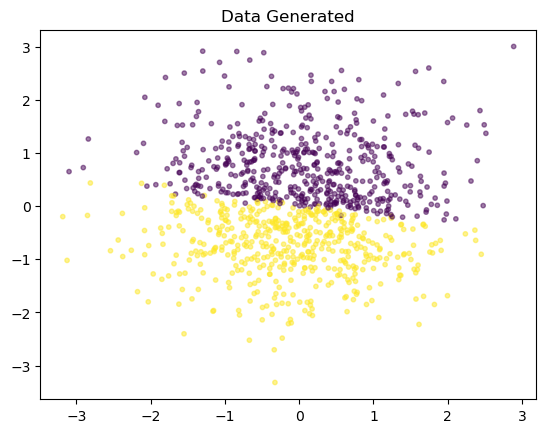

lmbda_t: 10
Empirical bound: 0.814610029914304
lmbda_t: 20
Empirical bound: 0.5069471216771769
lmbda_t: 30


/tmp/ipykernel_42073/4038806100.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/tmp/ipykernel_42073/4038806100.py:10: RuntimeWarning: invalid value encountered in scalar multiply
  first_sum += stats.norm.cdf( -y[i] * ( X[i] @ m / np.sqrt( X[i] @ np.diag(sigma2) @ X[i].T ) ) )
/tmp/ipykernel_42073/4038806100.py:13: RuntimeWarning: divide by zero encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k]/nu)


Empirical bound: 0.38596474778478457
lmbda_t: 40


/opt/conda/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Empirical bound: 0.3349086513604698
lmbda_t: 50
Empirical bound: 0.29572692108837584
lmbda_t: 60
Empirical bound: 0.26893910090697987
lmbda_t: 70
Empirical bound: 0.24251922934883988
lmbda_t: 80
Empirical bound: 0.25323949716262506
lmbda_t: 90
Empirical bound: 0.22598626260418517
lmbda_t: 100
Empirical bound: 0.22998763634376665
lmbda_t: 110
Empirical bound: 0.22535239667615148
lmbda_t: 120
Empirical bound: 0.21948969695313886
lmbda_t: 130
Empirical bound: 0.22499048949520511
lmbda_t: 140
Empirical bound: 0.1966543214783889
lmbda_t: 150
Empirical bound: 0.20722587754565971
lmbda_t: 160
Empirical bound: 0.215649260199056
lmbda_t: 170
Empirical bound: 0.19672871548146448
lmbda_t: 180
Empirical bound: 0.2183548979547164
lmbda_t: 190
Empirical bound: 0.20944148227288928
lmbda_t: 10
lmbda_t: 20
lmbda_t: 30
lmbda_t: 40
lmbda_t: 50
lmbda_t: 60
lmbda_t: 70
lmbda_t: 80
lmbda_t: 90
lmbda_t: 100
lmbda_t: 110
lmbda_t: 120
lmbda_t: 130
lmbda_t: 140
Missclassification rate, $\mathcal{F}_2$:  0.043


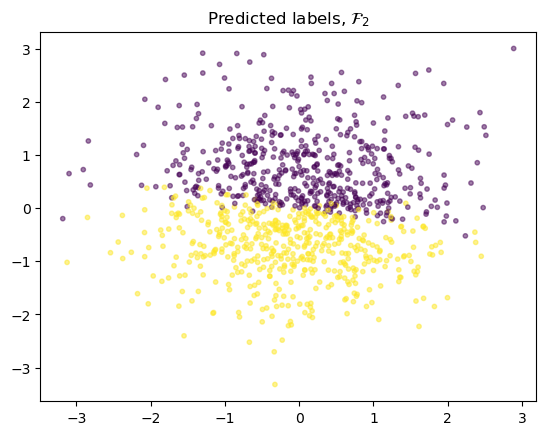

Missclassification rate, $\mathcal{F}_3$:  0.02


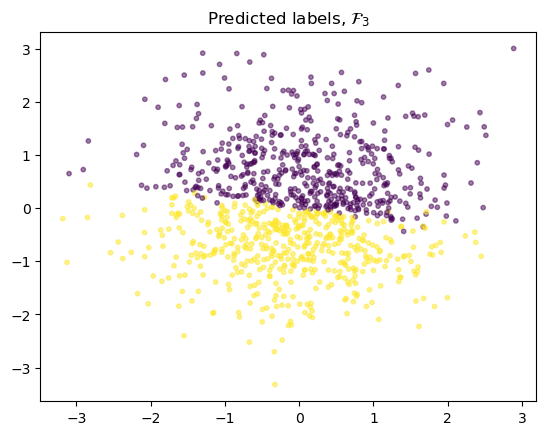

In [5]:
# Example 
## We generate some data
n, d = 1000, 2
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = 0.5 * (np.sign(X @ true_w + 0.1 * np.random.randn(n)) + 1)
# Plot the data 
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha = 0.5, cmap = 'viridis', s = 10)
plt.title("Data Generated")
plt.show()

# perform the DA
temperatures = list(range(10, 500, 10))
DA = DeterministicAnnealing(temperatures = temperatures, 
                            patience = 5, 
                            X = X, 
                            y = y, 
                            verbose = True)
m_F2, sigma2_F2, _, lmbda_star_F2 = DA.run_F2()
m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

ypred = []
for i in range(len(X)):
    beta = stats.multivariate_normal(mean = m_F2, cov = np.diag(sigma2_F2)).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
    
# Missclassification rate
print(r"Missclassification rate, $\mathcal{F}_2$: ", np.mean(ypred != y))

# Plot the data
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = ypred, alpha = 0.5, cmap = 'viridis', s = 10)
plt.title(r"Predicted labels, $\mathcal{F}_2$")
plt.show()

ypred = []
for i in range(len(X)):
    beta = stats.multivariate_normal(mean=m_F3, cov=Sigma_F3).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
    
# Missclassification rate
print(r"Missclassification rate, $\mathcal{F}_3$: ", np.mean(ypred != y))

# Plot the data
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = ypred, alpha = 0.5, cmap = 'viridis', s = 10)
plt.title(r"Predicted labels, $\mathcal{F}_3$")
plt.show()

## On real datasets

In [6]:
DATASET = ['pima-indians-diabetes',
           #'credit',
           'credit-g',
           #'dna', # more than 2 classes
           'spectf',
           #'glass', # more than 2 classes
           #'indian',
           'breast-cancer']

DATASET_DOWNLOAD = [fetch_openml(name = dataset, 
                                 version = 1) 
                                 for dataset in DATASET]

In [7]:
def preprocess_data(X):
    label_encoder = LabelEncoder()
    for col in X.columns:  # If X is a pandas dataframe
        if X[col].dtype == 'category':  # Only encode string columns
            X[col] = label_encoder.fit_transform(X[col])
    return X

In [ ]:
misclassification_rates_F2 = []
misclassification_rates_F3 = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    temperatures = list(range(10, 500, 10))
    DA = DeterministicAnnealing(temperatures=temperatures, patience=5, X=X, y=y, verbose=True)
    m_F2, sigma2_F2, empirical_bound_star, lmbda_star_F2 = DA.run_F2()
    m_F3, Sigma_F3 = DA.run_F3(lmbda_star_F2)

    print(f'Empirical bound for the optimal lambda={lmbda_star_F2} : {empirical_bound_star}')

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F2, cov=np.diag(sigma2_F2)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    print(f'Average misclassification rate, mean field: {np.mean(mis_rates)}')
    misclassification_rates_F2.append(np.mean(mis_rates))

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_F3, cov=Sigma_F3).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    
    print(f'Average misclassification rate, full covariance: {np.mean(mis_rates)}')
    misclassification_rates_F3.append(np.mean(mis_rates))
    
    print('\n'*3)

Pima-Indians-Diabetes
lmbda_t: 10
Empirical bound: 1.456870195214939
lmbda_t: 20
Empirical bound: 0.9234916625136194
lmbda_t: 30
Empirical bound: 0.7490927609294484
lmbda_t: 40
Empirical bound: 0.7010115568112358
lmbda_t: 50
Empirical bound: 0.5828273563971799
lmbda_t: 60
Empirical bound: 0.5779096409311204
lmbda_t: 70
Empirical bound: 0.5876973801991835
lmbda_t: 80
Empirical bound: 0.562950036096755
lmbda_t: 90
Empirical bound: 0.5208818740799527
lmbda_t: 100
Empirical bound: 0.5064312162982014
lmbda_t: 110
Empirical bound: 0.5029325097588367
lmbda_t: 120
Empirical bound: 0.5049549521306362
lmbda_t: 130
Empirical bound: 0.5272087870187938
lmbda_t: 140
Empirical bound: 0.5004959976902581
lmbda_t: 150
Empirical bound: 0.5046684846475065
lmbda_t: 160
Empirical bound: 0.5255943476522925
lmbda_t: 170
Empirical bound: 0.5161384325258946
lmbda_t: 180
Empirical bound: 0.5041642059759699
lmbda_t: 190
Empirical bound: 0.5215406386724777
lmbda_t: 10
lmbda_t: 20
lmbda_t: 30
lmbda_t: 40
lmbda_t: 5

100%|██████████| 10/10 [00:02<00:00,  3.99it/s]


Average misclassification rate, mean field: 0.29661458333333335


100%|██████████| 10/10 [00:02<00:00,  3.56it/s]
/tmp/ipykernel_42073/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_42073/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
/tmp/ipykernel_42073/2102543695.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

Average misclassification rate, full covariance: 0.292578125




credit-g
lmbda_t: 10
Empirical bound: 2.6720142157657474
lmbda_t: 20
Empirical bound: 1.5997499943509608
lmbda_t: 30
Empirical bound: 1.220818085373121
lmbda_t: 40


### Gibbs posterior with convexified loss

### Convex Classification and Hinge Loss

Compared to the previous section, convex classification offers significant advantages due to the nature of the corresponding variational approximation:

1. **Ease of Minimization**: The minimization problem becomes simpler as it involves a convex function.
2. **Integrated Risk Bound**: A bound for the integrated risk can be computed after a fixed number of minimization steps.

#### Setting
- The labels are now defined as \( Y = \{-1, 1\} \).
- The risk is based on the **hinge loss**:
  
  $$H = \frac{1}{n} \sum_{i=1}^n \max(0, 1 - Y_i \langle \theta, X_i \rangle).$$

#### Notation
- $R^H$ : The theoretical counterpart of the hinge risk.
- $ \bar{R}^H $: The minimum of $ R^H $ with respect to $ \theta $.
- The superscript $ H $ allows comparison with the risk $ R $ under the 0–1 loss.

#### Assumptions
- The covariates $ X_i $ are uniformly bounded: $ |X_i| < c_x $.
- Unlike previous sections, no additional assumptions (like (A1)) are required, as the results rely directly on the **Lipschitz continuity** of the hinge risk.


In [ ]:
def L_hinge(m, sigma, X, y, lmbda, nu): # lower bound to be maximized
    n, d = X.shape

    Gamma =np.tile(y, (d, 1)).T * X
    Gamma_norms = [np.sqrt(Gamma[i]@Gamma[i]) for i in range(n)]
    
    first_sum = 0
    second_sum = 0
    for i in range(n):
        first_sum += (1 - Gamma[i]@m) * stats.norm.cdf( (1 - Gamma[i]@m) / (sigma * Gamma_norms[i]) )
        second_sum += sigma * Gamma_norms[i] * stats.norm.pdf ( (1 - Gamma[i]@m) / (sigma * Gamma_norms[i]) )
        
    return -(lmbda/n)*( first_sum + second_sum ) - m@m / (2*nu) + 0.5*d*(np.log(sigma**2) - nu/sigma**2)

In [ ]:
class HingeLoss():
    def __init__(self, X, y):
        self.X = X
        self.y = 2*y - 1 # rescaler sur -1, 1
        self.n, self.d = X.shape
        self.sigma = 1/np.sqrt(self.n)
        self.nu = 1/np.sqrt(self.d)
        
    def cross_validate(self, lmbda, n_examples_test=1000):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        miss = []
        for (train_index, test_index) in skf.split(self.X, self.y):
            X_train, y_train = self.X[train_index], self.y[train_index]
            objective = lambda m: - L_hinge(m, self.sigma, X_train, y_train, lmbda, self.nu)
            x0 = np.zeros(self.d)
            result = minimize(
                fun=objective,
                x0=x0,
                method='L-BFGS-B'
            )
            m_star = result.x
            
            # regarder le taux de mauvaise classification sur le test set 
            ypred = []
            ytrue = []
            for _ in range(n_examples_test):
                i = np.random.choice(test_index)
                beta = stats.multivariate_normal(mean=m_star, cov=np.diag(np.ones(self.d)*self.sigma**2)).rvs()
                ypred.append(np.sign(self.X[i] @ beta))
                ytrue.append(self.y[i])
            ypred = np.array(ypred)
            ytrue = np.array(ytrue)

            miss.append(np.mean(ypred != ytrue))
        return np.mean(miss)
            
    def run(self, lmbdas):
        miss = {}
        for lmbda in lmbdas:
            print(f'lmbda: {lmbda}')
            miss[lmbda] = self.cross_validate(lmbda)
        self.lmbda_star = lmbdas[np.argmin(list(miss.values()))]
        return miss

    def fit_with_lmbda_star(self):
        objective = lambda m: - L_hinge(m, self.sigma, self.X, self.y, self.lmbda_star, self.nu)
        x0 = np.zeros(self.d)
        result = minimize(
            fun=objective,
            x0=x0,
            method='L-BFGS-B'
        )
        return result.x

In [ ]:
# Example 
## We generate some data
n, d = 1000, 2
X = np.random.randn(n, d)
true_w = np.random.randn(d)
y = 0.5 * (np.sign(X @ true_w + 0.1 * np.random.randn(n)) + 1)
# Plot the data 
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, alpha = 0.5, cmap = 'viridis', s = 10)
plt.title("Data Generated")
plt.show()

HL = HingeLoss(X=X, y=y)
miss = HL.run(lmbdas = np.logspace(0, 5, 12))
print(miss)
print(HL.lmbda_star)
print(miss[HL.lmbda_star])
print(HL.lmbda_star)
m_hinge = HL.fit_with_lmbda_star()

ypred = []
for i in range(len(X)):
    beta = stats.multivariate_normal(mean=m_hinge, cov=np.diag(np.ones(HL.d)*HL.sigma**2)).rvs()
    ypred.append(np.sign(X[i] @ beta))
print(np.mean(ypred != 2*y-1)) # Missclassification rate

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = ypred, alpha = 0.5, cmap = 'viridis', s = 10)
plt.title("Predicted labels")
plt.show()

In [ ]:
misclassification_rates_hinge = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    HL = HingeLoss(X=X, y=y)
    mis_rates = HL.run(lmbdas = np.logspace(0, 5, 12))
    print(mis_rates)
    misclassification_rates_hinge.append(min(mis_rates.values()))

### Support Vector Machine

In [ ]:
misclassification_rates = []
for i, dataset in enumerate(DATASET_DOWNLOAD):
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X)
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    C_range = np.logspace(-2, 2, 5)
    gamma_range = np.logspace(-2, 2, 5)
    param_grid = dict(gamma=gamma_range, C=C_range)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(SVC(kernel='rbf'), scoring='accuracy', param_grid=param_grid, cv=cv, verbose=2)
    grid.fit(X, y)
    misclassification_rates.append(1 - grid.best_score_)

In [ ]:
with open('results.txt', 'w') as file:
    for i, dataset in enumerate(DATASET_DOWNLOAD):
        file.write('='*100)
        file.write('\n')
        file.write('{}, {} variables, {} observations'.format(dataset.details['name'], dataset.data.shape[1], dataset.data.shape[0]))
        file.write('\n')
        file.write('='*100)
        # print('labels:', np.unique(dataset.target))
        file.write('\n')
        file.write('misclassification rate, Mean Field (F2): {} \n'.format(misclassification_rates_F2[i].round(3)))
        file.write('misclassification rate, Full cov. (F3): {} \n'.format(misclassification_rates_F3[i].round(3)))
        file.write('misclassification rate, Hinge loss: {} \n'.format(misclassification_rates_hinge[i].round(3)))
        file.write('misclassification rate, SVM: {}'.format(misclassification_rates[i].round(3)))
        file.write('\n')
        # file.write('='*100)
        file.write('\n'*3)

For comparison, the misclassification rates in the article were:

| Dataset   | Covariates | Mean Field (F2) | Full cov. (F3) | Hinge loss | SMC   | SVM   |
|-----------|------------|------------------|----------------|-------|-------|-------|
| Pima      | 7          | 31.0            | 21.3           |21.8 | 22.3  | 30.4  |
| Credit    | 60         | 32.0            | 33.6           |27.2 | 32.0  | 32.0  |
| DNA       | 180        | 23.6            | 23.6           |4.2  | 23.6  | 20.4  |
| SPECTF    | 22         | 08.0            | 06.9           |19.2 | 08.5  | 10.1  |
| Glass     | 10         | 34.6            | 19.6           |26.12| 23.3  | 4.7   |
| Indian    | 11         | 48.0            | 25.5           |26.2 | 26.2  | 26.8  |
| Breast    | 10         | 35.1            | 1.1            |0.5  | 1.1   | 1.7   |


## Ranking

### Problem Setting
- Labels: $Y = \{0, 1\}$.
- Linear classifiers: $\Theta = X = \mathbb{R}^d$, $f_\theta(x) = 1_{\langle \theta, x \rangle \geq 0}$.
- Objective: Not only classify individual objects $x$ correctly but also ensure that for any two objects:
  - The object more likely to correspond to label $1$ receives a higher score $f_\theta(x)$.

$ \quad $ 

### Risk Function
To measure performance, the **ranking risk function** is introduced:
$$
R(\theta) = P\left[(Y_1 - Y_2)(f_\theta(X_1) - f_\theta(X_2)) < 0\right],
$$
where the aim is to minimize the probability of misranking.


$ \quad $ 


### Empirical Risk
The empirical counterpart of the risk is defined as:
$$
r_n(\theta) = \frac{1}{n(n-1)} \sum_{1 \leq i \neq j \leq n} 1\{(Y_i - Y_j)(f_\theta(X_i) - f_\theta(X_j)) < 0\}.
$$

$ \quad $ 

### Classical Result
**Lemma 7.1**:  
Under the Hoeffding-type assumption, the concentration of the risk is characterized by:
$$
f(\lambda, n) = \frac{\lambda^2}{n - 1}.
$$
This ensures that the deviation between empirical and true risk can be controlled with high probability.

$ \quad $ 

### Definition : Assumption A2

We say that **Assumption A2** is satisfied when there exists a constant $c > 0$ such that, for any $(\theta, \theta') \in \Theta^2$ with $\|\theta\| = \|\theta'\| = 1$:
$$
P\left(\langle X_1 - X_2, \theta \rangle \langle X_1 - X_2, \theta' \rangle < 0\right) \leq c \|\theta - \theta'\|.
$$


#### Sufficient Condition
**Assumption A2** is satisfied if $\frac{X_1 - X_2}{\|X_1 - X_2\|}$ has a bounded density on the unit sphere.

In [15]:
def L_F2_ranking(m, sigma2, X, y, lmbda, nu):
    """ 
    Variational lower bound for mean field family, as defined page 16 
    Evaluated for given m, sigma2
    """
    # Convert X and y as arrays if not already
    X, y  = np.array(X), np.array(y)

    n, d = X.shape

    n_plus = np.sum(y)
    n_ = n - n_plus
    y_plus = y[y == 1]
    y_ = y[y == 0]
    X_plus = X[y == 1]
    X_ = X[y == 0]

    # Double sum
    first_double_sum = 0
    for i_plus in range(n_plus):
        for j_ in range(n_):
            SIGMA_ij = X_plus[i_plus] - X_[j_]
            first_double_sum += stats.norm.cdf( ( SIGMA_ij @ m ) / np.sqrt( SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T ) ) 

    # Single sum
    second_sum = 0
    for k in range(d):
        second_sum += np.log(sigma2[k]) - (sigma2[k] / nu)
        
    return - (lmbda / n_plus * n_) * first_double_sum - (m.T @ m) / (2 * nu) + second_sum / 2

This function is expensive to compute, as it involves $n + n^-$ terms, the computation of which is $O(p)$.

### **Algorithm 4: Stochastic Gradient Descent**

Input: $B$ a batch size, an unbiased estimator of the gradient $\nabla_B f$, $\eta \in (0, 1)$, and $c$.

**While** not converged:

a. $x_{t+1} = x_t - \lambda_t \nabla_B f(x_t)$  
b. Update $\lambda = \frac{1}{t^\eta}$  

**End Loop**

In all our experiments, we take $c = 1$ and $\eta = 0.9$.


In [23]:
def stochastic_gradient_descent(gradient_estimator, x_init, B, X, y, learning_rate = 0.9, c = 1, max_iter = 10 ** 4, tol = 1e-6):
    """
    Stochastic Gradient Descent (SGD) algorithm.
    
    Parameters:
    -----------
    gradient_estimator : function that estimates the gradient of the function to minimize
    x_init : initial value of x
    B (batch size): size of the batch for gradient estimation
    learning_rate : learning rate 
    c : initialization parameter for lambda 
    max_iter : maximum number of iterations 
    tol : tolerance for convergence 
    
    Returns:
    --------
    x : solution after optimization
    """

    # Initialization
    x = x_init
    lambda_t = 1.0  # Initial value of lambda

    # Main loop of the algorithm
    for t in range(1, max_iter + 1):
        # Estimate the gradient
        grad = gradient_estimator(x, B, X, y)
        
        # Update x
        x_new = x - lambda_t * grad
        
        # Check for convergence (based on the change in x)
        if np.linalg.norm(x_new - x) < tol:
            print(f"Convergence reached at iteration {t}")
            break
        
        lambda_t = 1 / ((t + c)** learning_rate)
        
        # Update x
        x = x_new
    
    return x

In [19]:
def compute_empirical_bound(X, y, m, sigma2, lmbda, nu, epsilon = 0.05, n_examples = 1000):
        n, d = X.shape
        # First get an approximation of the integrated risk
        ypred = []
        ytrue = []
        for _ in range(n_examples):
            i = np.random.randint(0, n)
            beta = stats.multivariate_normal(mean = m, cov = np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
            ytrue.append(y[i])
        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)
        # print(empirical_risk)

        # Compute the numerator of the last term
        numerator = np.sum([0.5 * np.log(nu ** 2 / sigma2[i] ** 2) + (sigma2[i] ** 2 / nu ** 2) for i in range(d)]) + (m@m / nu ** 2) - (d / 2) - np.log(epsilon)
        return empirical_risk + lmbda / (n - 1) + numerator / lmbda

In [ ]:
### Do not run this cell 
proba = 0.95 
B_pima = [1, 10, 20, 50]
B_adult = 50 


# Initialize the variables
nu = 0.1  # Some value for nu
X = np.random.randn(100, d)  # Example X, replace with actual data
y = np.random.randint(0, 2, size = 100)  # Example y, replace with actual labels
temperatures = list(range(10, 500, 10))
verbose = False
patience = 100

# Init
m_t = np.zeros(d)
sigma2_t = nu * np.ones(d)
params_t = np.concatenate([m_t, sigma2_t], axis = 0)
value_t = L_F2_ranking(params_t[:d], params_t[d:], X, y, 0, nu)  # max L_F2_ranking
empirical_bound_star = np.inf
bounds = []

# Loop
p = 0  # patience counter
for ix, lmbda_t in enumerate(temperatures):
    if verbose:
        print(lmbda_t)
    
    params_prev = params_t.copy()
    
    # Gradient estimator function
    def gradient_estimator(params, B, X, y):
        # Convert X and y as arrays if not already
        X, y  = np.array(X), np.array(y)

        n, d = X.shape

        n_plus = np.sum(y)
        n_ = n - n_plus
        y_plus = y[y == 1]
        y_ = y[y == 0]
        X_plus = X[y == 1]
        X_ = X[y == 0]
        sigma2, m = params[d:], params[:d]

        # gradient_sigma2
        gradient_sigma2 = [(1 / sigma2[k] - (1 / nu)) / 2 for k in range(d)]  
        second_term = np.zeros(d) 

        # gradient_m
        gradient_m = np.zeros(d)
        for i_plus in range(n_plus):
            for j_ in range(n_):
                SIGMA_ij = X_plus[i_plus] - X_[j_]
                
                gradient_m += [stats.norm.cdf( ( np.dot(SIGMA_ij, m) ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) )) * stats.norm.pdf( - ( SIGMA_ij * m[i] ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) )) for i in range(d)][0]
                second_term += [stats.norm.cdf( ( np.dot(SIGMA_ij, m) ) / np.sqrt( np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T) ) ) * stats.norm.pdf((( np.dot(SIGMA_ij, m) ) / 2) * SIGMA_ij[i] * (np.dot(np.dot(SIGMA_ij, np.diag(sigma2)), SIGMA_ij.T)) ** (-3 / 2)) for i in range(d)][0]
                
        gradient_m =  - (lmbda_t / n_plus * n_) * gradient_m - m / nu   
        gradient_sigma2 = - (lmbda_t / n_plus * n_) * second_term + gradient_sigma2

        gradient = np.concatenate([gradient_m, gradient_sigma2])
        return gradient
    
    # Run SGD to optimize the parameters
    params_t = stochastic_gradient_descent(gradient_estimator, params_prev, X = X, y = y, B = 10, learning_rate = 0.9, c = 1, max_iter = 10 ** 4, tol = 1e-6)
    
    m_t = params_t[:d]
    sigma2_t = params_t[d:]
    empirical_bound_t = compute_empirical_bound(m_t, sigma2_t, lmbda_t, 0.05)
    bounds.append(empirical_bound_t)
    if verbose:
        print(empirical_bound_t)
    
    if empirical_bound_t > empirical_bound_star:
        p += 1
        if p == patience:
            m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t
            print(f"Converged with lmbda_t = {lmbda_t}")
            break
    else:
        p = 0
        m_star, sigma2_star, empirical_bound_star, lmbda_star = m_t.copy(), sigma2_t.copy(), empirical_bound_t, lmbda_t


In [2]:
class RunRanking:
    def __init__(self, nu, X, y, temperatures, verbose = False, patience = 10):
        self.nu = nu
        self.X = np.array(X)
        self.y = np.array(y)
        self.temperatures = temperatures
        self.verbose = verbose
        self.patience = patience
        self.d = self.X.shape[1]
        self.m_t = np.zeros(self.d)
        self.sigma2_t = self.nu * np.ones(self.d)
        self.params_t = np.concatenate([self.m_t, self.sigma2_t], axis=0)
        self.bounds = []
        self.empirical_bound_star = np.inf

    def L_F2_ranking(self, m, sigma2, lmbda):
        """ 
        Variational lower bound for mean field family, as defined page 16 
        Evaluated for given m, sigma2
        """
        X, y = self.X, self.y
        n, d = X.shape

        n_plus = np.sum(y)
        n_ = n - n_plus
        X_plus = X[y == 1]
        X_ = X[y == 0]

        # Double sum
        first_double_sum = 0
        for i_plus in range(n_plus):
            for j_ in range(n_):
                SIGMA_ij = X_plus[i_plus] - X_[j_]
                first_double_sum += stats.norm.cdf((SIGMA_ij @ m) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T))

        # Single sum
        second_sum = 0
        for k in range(d):
            second_sum += np.log(sigma2[k]) - (sigma2[k] / self.nu)

        return - (lmbda / (n_plus * n_)) * first_double_sum - (m.T @ m) / (2 * self.nu) + second_sum / 2

    def stochastic_gradient_descent(self, gradient_estimator, x_init, B, learning_rate = 0.9, c = 1, max_iter = 10 ** 2, tol = 1e-3):
        """
        Stochastic Gradient Descent (SGD) algorithm.
        """
        x = x_init
        lambda_t = 1.0

        for t in tqdm(range(1, max_iter + 1), desc = "Optimization in progress"):
            grad = gradient_estimator(x, B)
            x_new = x - lambda_t * grad

            if np.linalg.norm(x_new - x) < tol:
                if self.verbose:
                    print(f"Convergence reached at iteration {t}")
                break

            lambda_t = 1 / ((t + c) ** learning_rate)
            x = x_new

        return x

    def compute_empirical_bound(self, m, sigma2, lmbda, epsilon = 0.05, n_examples = 10 ** 4):
        n, d = self.X.shape
        ypred = []
        ytrue = []

        for _ in range(n_examples):
            i = np.random.randint(0, n)
            beta = stats.multivariate_normal(mean=m, cov=np.diag(sigma2)).rvs()
            ypred.append(0.5 * (np.sign(self.X[i] @ beta) + 1))
            ytrue.append(self.y[i])

        ypred = np.array(ypred)
        ytrue = np.array(ytrue)
        empirical_risk = np.mean(ypred != ytrue)

        numerator = np.sum([0.5 * np.log(self.nu ** 2 / sigma2[i] ** 2) + (sigma2[i] ** 2 / self.nu ** 2) for i in range(d)])
        numerator += (m @ m / self.nu ** 2) - (d / 2) - np.log(epsilon)

        return empirical_risk + lmbda / (n - 1) + numerator / lmbda

    def gradient_estimator(self, params, B):
        X, y = self.X, self.y
        n, d = X.shape

        n_plus = np.sum(y)
        n_ = n - n_plus
        X_plus = X[y == 1]
        X_ = X[y == 0]

        sigma2, m = params[d:], params[:d]
        gradient_sigma2 = [(1 / sigma2[k] - (1 / self.nu)) / 2 for k in range(d)]  
        second_term = np.zeros(d)
        gradient_m = np.zeros(d)

        for i_plus in range(n_plus):
            for j_ in range(n_):
                SIGMA_ij = X_plus[i_plus] - X_[j_]
                gradient_m += [stats.norm.cdf((SIGMA_ij @ m) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T)) *
                               stats.norm.pdf(-(SIGMA_ij * m[i]) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T))
                               for i in range(d)][0]
                second_term += [stats.norm.cdf((SIGMA_ij @ m) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T)) *
                                stats.norm.pdf(((SIGMA_ij @ m) / 2) * SIGMA_ij[i] *
                                               (SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T) ** (-3 / 2))
                                for i in range(d)][0]

        gradient_m = -(self.temperatures[0] / (n_plus * n_)) * gradient_m - m / self.nu
        gradient_sigma2 = -(self.temperatures[0] / (n_plus * n_)) * second_term + gradient_sigma2

        return np.concatenate([gradient_m, gradient_sigma2])

    def RUN(self, opti_method = 'SGD'):
        p = 0
        for ix, lmbda_t in enumerate(self.temperatures):
            if self.verbose:
                print(lmbda_t)

            params_prev = self.params_t.copy()

            if opti_method == 'SGD':
                self.params_t = self.stochastic_gradient_descent(
                    self.gradient_estimator, params_prev, B = 10, learning_rate = 0.9, c = 1, max_iter = 10**2, tol = 1e-3
                )
            else:

            # il faut faire la reparamétrisatiion
                objective_t = lambda params: - self.L_F2_ranking(params[:self.d], params[self.d:], lmbda_t)
                result = minimize(
                    fun = objective_t,
                    x0 = params_prev,
                    method='L-BFGS-B'
                    )
                params_t = result.x
            if self.verbose:
                print("Stochastic gradient descent achieved")

            self.m_t = self.params_t[:self.d]
            self.sigma2_t = self.params_t[self.d:]
            empirical_bound_t = self.compute_empirical_bound(self.m_t, self.sigma2_t, lmbda_t)
            self.bounds.append(empirical_bound_t)

            if self.verbose:
                print(empirical_bound_t)

            if empirical_bound_t > self.empirical_bound_star:
                p += 1
                if self.verbose:
                    print(f"p = {p}")
                if p == self.patience:
                    self.m_star, self.sigma2_star, self.empirical_bound_star, self.lmbda_star = (
                        self.m_t.copy(), self.sigma2_t.copy(), empirical_bound_t, lmbda_t
                    )
                    print(f"Converged with lmbda_t = {lmbda_t}")
                    break
            else:
                p = 0
                self.m_star, self.sigma2_star, self.empirical_bound_star, self.lmbda_star = (
                    self.m_t.copy(), self.sigma2_t.copy(), empirical_bound_t, lmbda_t
                )
        return self.m_star, self.sigma2_star, self.empirical_bound_star, self.bounds, self.lmbda_star

10
Stochastic gradient descent achieved
1.0002833283655002
20
Stochastic gradient descent achieved


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11123/749263624.py:34: RuntimeWarning: invalid value encountered in sqrt
  first_double_sum += stats.norm.cdf((SIGMA_ij @ m) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T))
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11123/749263624.py:39: RuntimeWarning: invalid value encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k] / self.nu)


0.8956068156979016
30
Stochastic gradient descent achieved
0.9352213788154361
p = 1
40
Stochastic gradient descent achieved
1.0017337108792537
p = 2
50
Stochastic gradient descent achieved
1.083065150521585
p = 3
60
Stochastic gradient descent achieved
1.1785561439531724
p = 4
70
Stochastic gradient descent achieved
1.2615525966929069
p = 5
80
Stochastic gradient descent achieved
1.3605274615002327
p = 6
90
Stochastic gradient descent achieved
1.45118793435262
p = 7
100
Stochastic gradient descent achieved
1.54485833283655
p = 8
110
Stochastic gradient descent achieved
1.6500359499616022
p = 9
120
Stochastic gradient descent achieved
1.7498189810674953
p = 10
Converged with lmbda_t = 120


100%|██████████| 100/100 [00:00<00:00, 11596.73it/s]


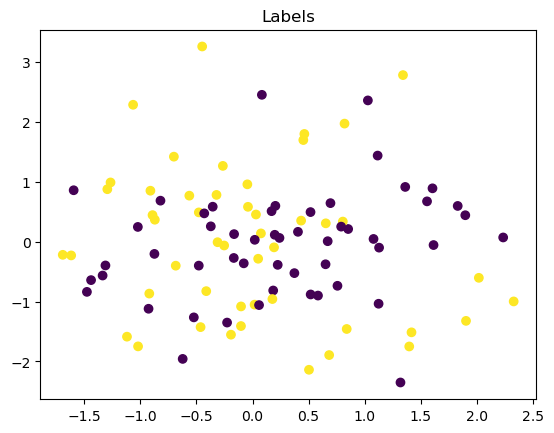

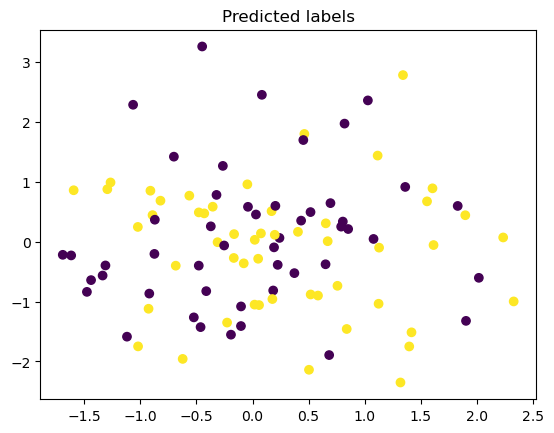

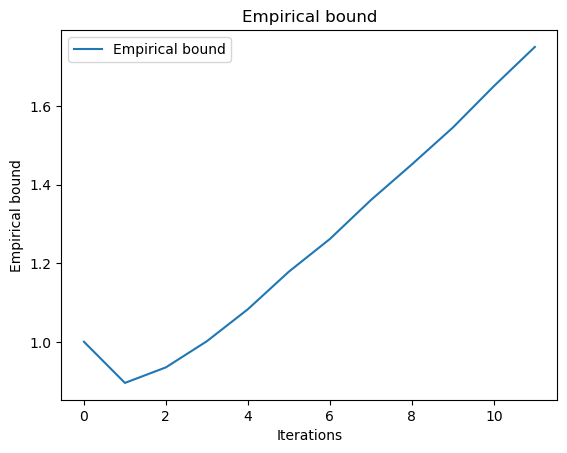

In [8]:
nu = 0.1  
d = 2
X = np.random.randn(100, d) 
y = np.random.randint(0, 2, size = 100)  
temperatures = list(range(10, 500, 10))

RR = RunRanking(nu, X, y, temperatures, verbose = True, patience = 10)
m_star, sigma2_star, empirical_bound_star, bounds, lmbda_star = RR.RUN(opti_method = 'L-BFGS-B')

ypred = []
for i in tqdm(range(len(X))):
    beta = stats.multivariate_normal(mean = m_star, cov = np.diag(sigma2_star)).rvs()
    ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))


plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = y)
plt.title("Labels")
plt.show()

plt.figure()
plt.scatter(X[:, 0], X[:, 1], c = ypred)
plt.title("Predicted labels")
plt.show()

plt.figure()
plt.plot(list(range(len(bounds))), bounds, label = "Empirical bound")
plt.title("Empirical bound")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Empirical bound")
plt.grid()
plt.show()

In [13]:
misclassification_rates_ranking = []
pima_data = fetch_openml(name = 'pima-indians-diabetes', version = 1)  # pima dataset
adult_data = fetch_openml(data_id = 1590, as_frame = True)  # adult dataset
DATASET_DOWNLOAD_ranking = [pima_data, adult_data]


for i, dataset in enumerate(DATASET_DOWNLOAD_ranking):
    print('='*100)
    print(dataset.details['name'])
    print('='*100, end='\n')
    X, y = dataset['data'], dataset['target']
    X = preprocess_data(X).to_numpy()
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = pd.factorize(y)[0]
    
    temperatures = list(range(10, 500, 10))
    RR = RunRanking(nu, X, y, temperatures = [100], verbose = True, patience = 10)
    m_star, sigma2_star, empirical_bound_star, lmbda_star = RR.RUN(opti_method = 'L-BFGS-B')

    print(f'Empirical bound for the optimal lambda={lmbda_star_F2} : {empirical_bound_star}')

    mis_rates = []
    for _ in tqdm(range(10)):
        ypred = []
        for i in range(len(X)):
            beta = stats.multivariate_normal(mean=m_star, cov=np.diag(sigma2_star)).rvs()
            ypred.append(0.5 * (np.sign(X[i] @ beta) + 1))
        mis_rate = (ypred != y).mean()
        mis_rates.append(mis_rate)
    print(f'Average misclassification rate, mean field: {np.mean(mis_rates)}')
    misclassification_rates_ranking.append(np.mean(mis_rates))
    
    print('\n'*3)

Pima-Indians-Diabetes
100


/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11123/749263624.py:34: RuntimeWarning: invalid value encountered in sqrt
  first_double_sum += stats.norm.cdf((SIGMA_ij @ m) / np.sqrt(SIGMA_ij @ np.diag(sigma2) @ SIGMA_ij.T))
/var/folders/t6/khg6jj9s4_b0lqrt24p4bvs00000gn/T/ipykernel_11123/749263624.py:39: RuntimeWarning: invalid value encountered in log
  second_sum += np.log(sigma2[k]) - (sigma2[k] / self.nu)


Stochastic gradient descent achieved
0.7070354192153313


ValueError: too many values to unpack (expected 4)

# Conclusion 

# Questions ? 